## Volatility Estimator

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from itertools import combinations
from datetime import timedelta
import yfinance as yf
from arch import arch_model

#### Exploration

In [163]:
data = yf.download('AAPL', start="2018-01-1",interval="1d")
data['log_returns'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

print(data.head(), 
      "\n"*3,
      data.tail())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume log_returns
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL            
Date                                                                         
2018-01-03  40.334869  40.878196  40.271640  40.405128  118071600   -0.000174
2018-01-04  40.522209  40.625254  40.299728  40.407454   89738400    0.004634
2018-01-05  40.983566  41.070216  40.526893  40.618228   94640000    0.011321
2018-01-08  40.831356  41.126437  40.732992  40.831356   82271200   -0.003721
2018-01-09  40.826672  40.997631  40.611215  40.878194   86336000   -0.000115 


 Price            Close        High         Low        Open    Volume  \
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL   
Date                                                                   
2025-12-24  273.809998  275.429993  272.200012  272.339996  17910600   
2025-12-26  273.399994  275.369995  272.859985  274.160004  21521800   
2025-12-29  

In [164]:
tickers = yf.Tickers('MSFT AAPL GOOG')
tickers.tickers['MSFT'].info
yf.download(['MSFT', 'AAPL', 'GOOG'], period='1y')

[*********************100%***********************]  3 of 3 completed


Price            Close                                High              \
Ticker            AAPL        GOOG        MSFT        AAPL        GOOG   
Date                                                                     
2025-01-02  242.752090  189.890747  415.514832  247.978453  192.450773   
2025-01-03  242.264297  192.381042  420.249939  243.080598  193.745725   
2025-01-06  243.896912  197.192337  424.716949  246.216423  198.786123   
2025-01-07  241.119476  195.947174  419.277069  244.444435  201.356109   
2025-01-08  241.607269  194.632278  421.451080  242.612732  196.873553   
...                ...         ...         ...         ...         ...   
2025-12-24  273.809998  315.670013  488.019989  275.429993  316.290009   
2025-12-26  273.399994  314.959991  487.709991  275.369995  316.559998   
2025-12-29  273.760010  314.390015  487.100006  274.359985  314.970001   
2025-12-30  273.079987  314.549988  487.480011  274.079987  317.700012   
2025-12-31  271.859985  313.799988  483.619995  273.679993  315.390015   

Price                          Low                                Open  \
Ticker            MSFT        AAPL        GOOG        MSFT        AAPL   
Date                                                                     
2025-01-02  422.950005  240.731232  187.978195  411.812165  247.809205   
2025-01-03  420.924952  240.800915  190.607947  416.467841  242.264297   
2025-01-06  431.139572  242.105013  194.303574  422.364309  243.210016   
2025-01-07  427.496435  240.263348  195.180156  417.718559  241.885999   
2025-01-08  423.843436  238.969207  192.998639  418.453206  240.830782   
...                ...         ...         ...         ...         ...   
2025-12-24  489.160004  272.200012  313.320007  484.829987  272.339996   
2025-12-26  488.119995  272.859985  313.720001  485.959991  274.160004   
2025-12-29  488.350006  272.350006  311.899994  484.179993  272.690002   
2025-12-30  489.679993  272.279999  313.250000  485.500000  272.809998   
2025-12-31  488.140015  271.750000  312.200012  483.299988  273.059998   

Price                                 Volume                      
Ticker            GOOG        MSFT      AAPL      GOOG      MSFT  
Date                                                              
2025-01-02  190.742427  422.413951  55740700  17545200  16896500  
2025-01-03  191.977614  417.996542  40244100  12875000  16662900  
2025-01-06  194.393221  424.865845  45045600  19483300  20573600  
2025-01-07  197.501122  425.858524  40856000  16966800  18139100  
2025-01-08  193.197860  420.359129  37628900  14335300  15054600  
...                ...         ...       ...       ...       ...  
2025-12-24  316.149994  485.679993  17910600   6138200   5855900  
2025-12-26  315.920013  486.709991  21521800   6730900   8842200  
2025-12-29  312.820007  484.859985  23715200  12317700  10893400  
2025-12-30  313.410004  485.929993  22139600  11052500  13944500  
2025-12-31  313.369995  487.839996  27278500  10814800  15590800  

[250 rows x 15 columns]

#### Tickers List

In [165]:
tickers = {
    'Actions Europe': ['MC.PA', 'SAP.DE', 'ASML.AS'],
    'Actions Amérique': ['AAPL', 'TSLA', 'JPM'],
    'Actions Asie': ['7203.T', '0700.HK', 'RELIANCE.NS'],
    'ETF': ['SPY', 'VGK', 'EWJ'],
    'Obligations': ['AGG', 'TLT'],
    'Commodities': ['GC=F', 'CL=F'],
    'Devises': ['EURUSD=X', 'USDJPY=X'],
    'Crypto': ['BTC-USD', 'ETH-USD']
}

rename_dict = {
    # Actions Europe
    'MC.PA': 'LVMH_France',
    'SAP.DE': 'SAP_Germany',
    'ASML.AS': 'ASML_Netherlands',
    'NESN.SW': 'Nestle_Switzerland',
    'VOD.L': 'Vodafone_UK',
    'SAN.MC': 'Santander_Spain',
    'ENI.MI': 'ENI_Italy',
    
    # Actions Amérique
    'AAPL': 'Apple_US',
    'TSLA': 'Tesla_US',
    'JPM': 'JPMorgan_US',
    'VALE': 'Vale_Brazil',
    'TD.TO': 'TD_Bank_Canada',
    
    # Actions Asie
    '7203.T': 'Toyota_Japan',
    'BABA': 'Alibaba_China',
    '005930.KS': 'Samsung_Korea',
    '0700.HK': 'Tencent_HongKong',
    'RELIANCE.NS': 'Reliance_India',
    
    # ETF et Indices Europe
    'EXSA.DE': 'ETF_Europe600',
    'VGK': 'ETF_FTSE_Europe',
    '^STOXX50E': 'Index_EuroStoxx50',
    
    # ETF et Indices Amérique
    'SPY': 'ETF_SP500',
    'QQQ': 'ETF_Nasdaq100',
    'EWZ': 'ETF_Brazil',
    
    # ETF et Indices Asie
    'EWJ': 'ETF_Japan',
    'MCHI': 'ETF_China',
    '^N225': 'Index_Nikkei225',
    '^HSI': 'Index_HangSeng',
    
    # Obligations
    'AGG': 'Bond_US_Aggregate',
    'TLT': 'Bond_Treasury_20Y',
    'LQD': 'Bond_InvestmentGrade',
    'HYG': 'Bond_HighYield',
    'VWOB': 'Bond_EmergingMarkets',
    
    # Matières premières
    'GC=F': 'Gold_Futures',
    'SI=F': 'Silver_Futures',
    'CL=F': 'Oil_WTI',
    'NG=F': 'NaturalGas_Futures',
    'HG=F': 'Copper_Futures',
    
    # Devises
    'EURUSD=X': 'FX_EUR_USD',
    'GBPUSD=X': 'FX_GBP_USD',
    'USDJPY=X': 'FX_USD_JPY',
    'AUDUSD=X': 'FX_AUD_USD',
    'USDCNY=X': 'FX_USD_CNY',
    
    # Cryptomonnaies
    'BTC-USD': 'Bitcoin',
    'ETH-USD': 'Ethereum',
    'BNB-USD': 'Binance',
    'ADA-USD': 'Cardano',
    'SOL-USD': 'Solana'
}


#### Computing log returns 

Log returns are essential to compute volatility. It is the basis of calculation of historic volatility

In [166]:
all_tickers = [t for category in tickers.values() for t in category]
all_data = yf.download(all_tickers, start='2020-03-01', end ='2020-12-30')
all_data.dropna(inplace=True)
all_data = all_data.rename(columns=rename_dict)

log_returns = np.log(all_data['Close'] / all_data['Close'].shift(1))
log_returns.dropna(inplace=True)

#print(all_data.head(),"\n"*5,all_data.tail())
print(log_returns.head(),"\n"*5, log_returns.tail())

[*********************100%***********************]  20 of 20 completed


Ticker      Tencent_HongKong  Toyota_Japan  Apple_US  Bond_US_Aggregate  \
Date                                                                      
2020-03-03          0.011230     -0.015496 -0.032274           0.006791   
2020-03-04          0.000000     -0.009987  0.045341          -0.000771   
2020-03-05          0.030495      0.004864 -0.032975           0.003082   
2020-03-06         -0.025937     -0.031013 -0.013369           0.007323   
2020-03-09         -0.047604     -0.045007 -0.082395          -0.001273   

Ticker      ASML_Netherlands   Bitcoin   Oil_WTI  Ethereum  FX_EUR_USD  \
Date                                                                     
2020-03-03          0.035525 -0.009275  0.009156 -0.026769    0.008356   
2020-03-04          0.017016 -0.003710 -0.008514  0.000171    0.003282   
2020-03-05         -0.003228  0.036285 -0.018991  0.020937   -0.003727   
2020-03-06         -0.045126  0.004811 -0.106087  0.060328    0.007581   
2020-03-09         -0.061969 -

/opt/anaconda3/lib/python3.13/site-packages/pandas/core/internals/blocks.py:395: RuntimeWarning:

invalid value encountered in log



### 1. Historic Volatility over the considered period

La volatilité historique (ou réalisée) est une mesure statistique de la dispersion des rendements passés d'un actif financier, calculée comme l'écart-type des rendements logarithmiques sur une période donnée. Elle quantifie l'amplitude des fluctuations de prix, à la hausse comme à la baisse, sans préjuger de leur direction. Concrètement, on calcule les rendements logarithmiques (log_returns) ln(Pt/P(t−1)), puis on détermine leur écart-type que l'on annualise en multipliant par sqrt(252) pour obtenir une volatilité annuelle.
Autrement dit, on a σ(annuel)=σ(quotidien)× sqrt(252)

L'explication vient du fait que l'on considère que les rendement sont indépendants et identiquements distribués (ce qui est une approximation car il y a de l'autocorrélation, du clustering)
On a alors Var(r1+r2+...+rN) = N Var(r1)
Et σ(ri) = sqrt(Var(ri)) donc σ(rN) = sqrt(Var(rN)) = sqrt(N*Var(r1)) = sqrt(N)*sqrt(Var(r1)) = sqrt(N)*σ(r1)
Il suffit maintenant de remplacer N par 252 (le nombre de jours d'ouverture du marché).

In [167]:
simple_volatility = log_returns.std() * np.sqrt(252)
print(f"Volatilité historique annualisée: {simple_volatility.round(5)}")

Volatilité historique annualisée: Ticker
Tencent_HongKong     0.40883
Toyota_Japan         0.32245
Apple_US             0.51034
Bond_US_Aggregate    0.10413
ASML_Netherlands     0.44078
Bitcoin              0.90108
Oil_WTI              1.29670
Ethereum             1.16059
FX_EUR_USD           0.08679
ETF_Japan            0.27910
Gold_Futures         0.24238
JPMorgan_US          0.63243
LVMH_France          0.40067
Reliance_India       0.50707
SAP_Germany          0.47243
ETF_SP500            0.37142
Bond_Treasury_20Y    0.27177
Tesla_US             0.94574
FX_USD_JPY           0.08844
ETF_FTSE_Europe      0.39064
dtype: float64


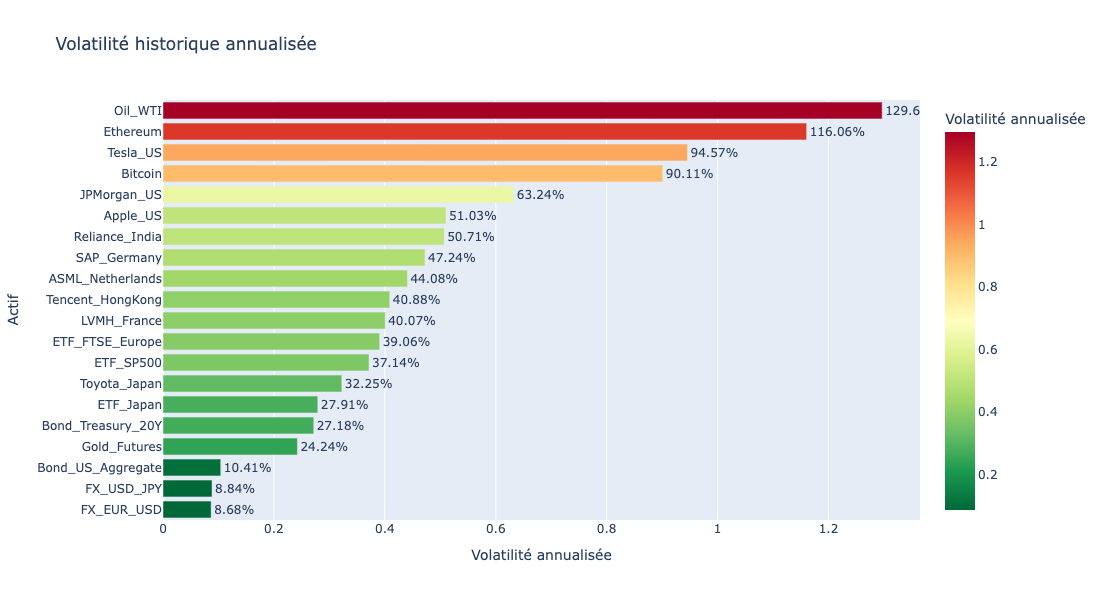

In [168]:
vol_df = simple_volatility.reset_index()
vol_df.columns = ['Actif', 'Volatilité']
vol_df['Volatilité_pct'] = (vol_df['Volatilité'] * 100).round(2)
vol_df = vol_df.sort_values('Volatilité')

fig = px.bar(vol_df, 
             y='Actif', 
             x='Volatilité',
             orientation='h',
             color='Volatilité',
             color_continuous_scale='RdYlGn_r',
             text='Volatilité_pct',
             labels={'Volatilité': 'Volatilité annualisée'},
             title='Volatilité historique annualisée')

fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig.update_layout(height=600, showlegend=False)
fig.show()

### 2. Rolling Window Volatility

In [169]:
vol_20d = log_returns.rolling(window=20).std() * np.sqrt(252)
vol_60d = log_returns.rolling(window=60).std() * np.sqrt(252)
vol_120d = log_returns.rolling(window=120).std() * np.sqrt(252)

# Visualiser les dernières valeurs
print(vol_20d.tail(),
      "\n"*5,
     vol_60d.tail(),
      "\n"*5,
     vol_120d.tail())

Ticker      Tencent_HongKong  Toyota_Japan  Apple_US  Bond_US_Aggregate  \
Date                                                                      
2020-12-21          0.274293      0.253430  0.295376           0.022333   
2020-12-22          0.256428      0.256733  0.307369           0.021931   
2020-12-23          0.237528      0.258941  0.304862           0.021767   
2020-12-28          0.409957      0.267480  0.318086           0.021288   
2020-12-29          0.418252      0.265094  0.327530           0.021225   

Ticker      ASML_Netherlands   Bitcoin   Oil_WTI  Ethereum  FX_EUR_USD  \
Date                                                                     
2020-12-21          0.223853  0.731896  0.301985  1.110763    0.056318   
2020-12-22          0.237485  0.737864  0.310523  1.109691    0.055327   
2020-12-23          0.235224  0.740524  0.316264  1.136335    0.058951   
2020-12-28          0.236273  0.895576  0.239737  1.250982    0.057620   
2020-12-29          0.230076  

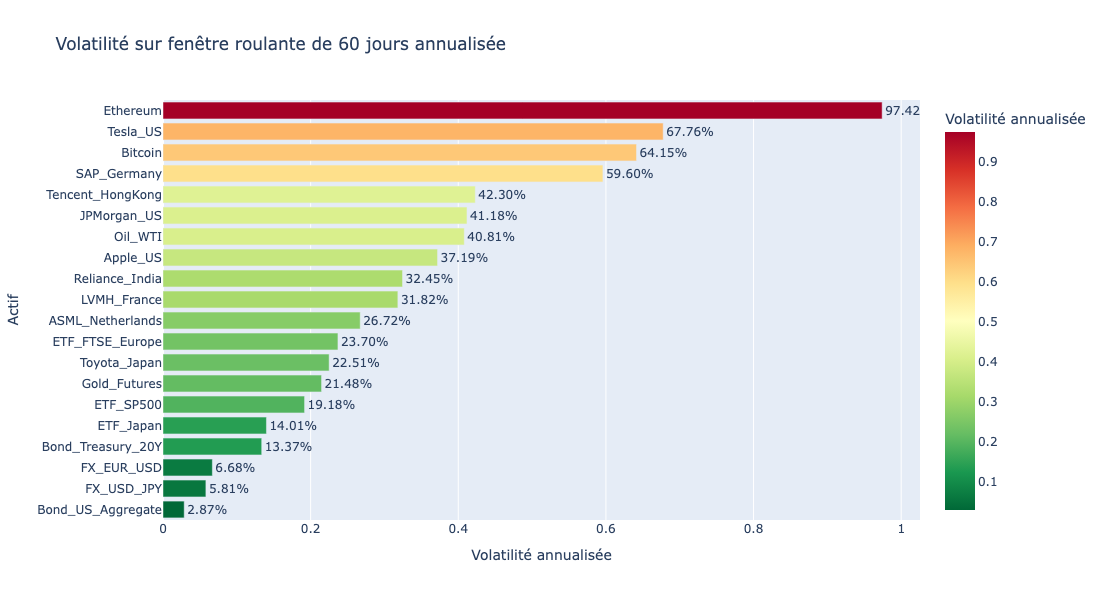

In [177]:
vol_roll_df = vol_60d.iloc[-1].reset_index()
vol_roll_df.columns = ['Actif', 'Volatilité']
vol_roll_df['% Volatilité'] = (vol_roll_df['Volatilité'] * 100).round(2)
vol_roll_df = vol_roll_df.sort_values('Volatilité')

fig2 = px.bar(vol_roll_df, 
             y='Actif', 
             x='Volatilité',
             orientation='h',
             color='Volatilité',
             color_continuous_scale='RdYlGn_r',
             text='% Volatilité',
             labels={'Volatilité': 'Volatilité annualisée'},
             title=f'Volatilité sur fenêtre roulante de 60 jours annualisée')

fig2.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig2.update_layout(height=600, showlegend=False)
fig2.show()

### 3. Exponentially Weighted Moving Average

L'EWMA (Exponentially Weighted Moving Average) est une méthode de calcul de volatilité qui attribue plus de poids aux observations récentes et moins aux observations anciennes, grâce à un paramètre de lissage λ (lambda) généralement fixé à 0,94. La formule récursive est σ(n)^2 = λ*σ(n−1)^2 +(1−λ)*r(n−1)^2

Cela signifie que la variance d'aujourd'hui dépend de la variance d'hier pondérée par λ et du rendement carré d'hier pondéré par (1-λ). Cette approche capture plus rapidement les chocs de marché récents que la volatilité historique simple, qui donne un poids égal à toutes les observations.


In [171]:
lambda_param = 0.94
alpha_param = 1 - lambda_param

ewma_variance = log_returns.ewm(alpha=alpha_param, adjust=False).var()
ewma_volatility = np.sqrt(ewma_variance * 252)

print(ewma_volatility.tail(3))

Ticker      Tencent_HongKong  Toyota_Japan  Apple_US  Bond_US_Aggregate  \
Date                                                                      
2020-12-23          0.337074      0.237099  0.329681           0.025450   
2020-12-28          0.488902      0.243107  0.352163           0.024959   
2020-12-29          0.486112      0.239574  0.349875           0.024199   

Ticker      ASML_Netherlands   Bitcoin   Oil_WTI  Ethereum  FX_EUR_USD  \
Date                                                                     
2020-12-23          0.261441  0.646587  0.356251  0.934868    0.060509   
2020-12-28          0.258175  0.820022  0.350122  1.234928    0.058728   
2020-12-29          0.251405  0.796619  0.339859  1.199028    0.056995   

Ticker      ETF_Japan  Gold_Futures  JPMorgan_US  LVMH_France  Reliance_India  \
Date                                                                            
2020-12-23   0.129987      0.188951     0.366800     0.237625        0.269535   
2020-12-28

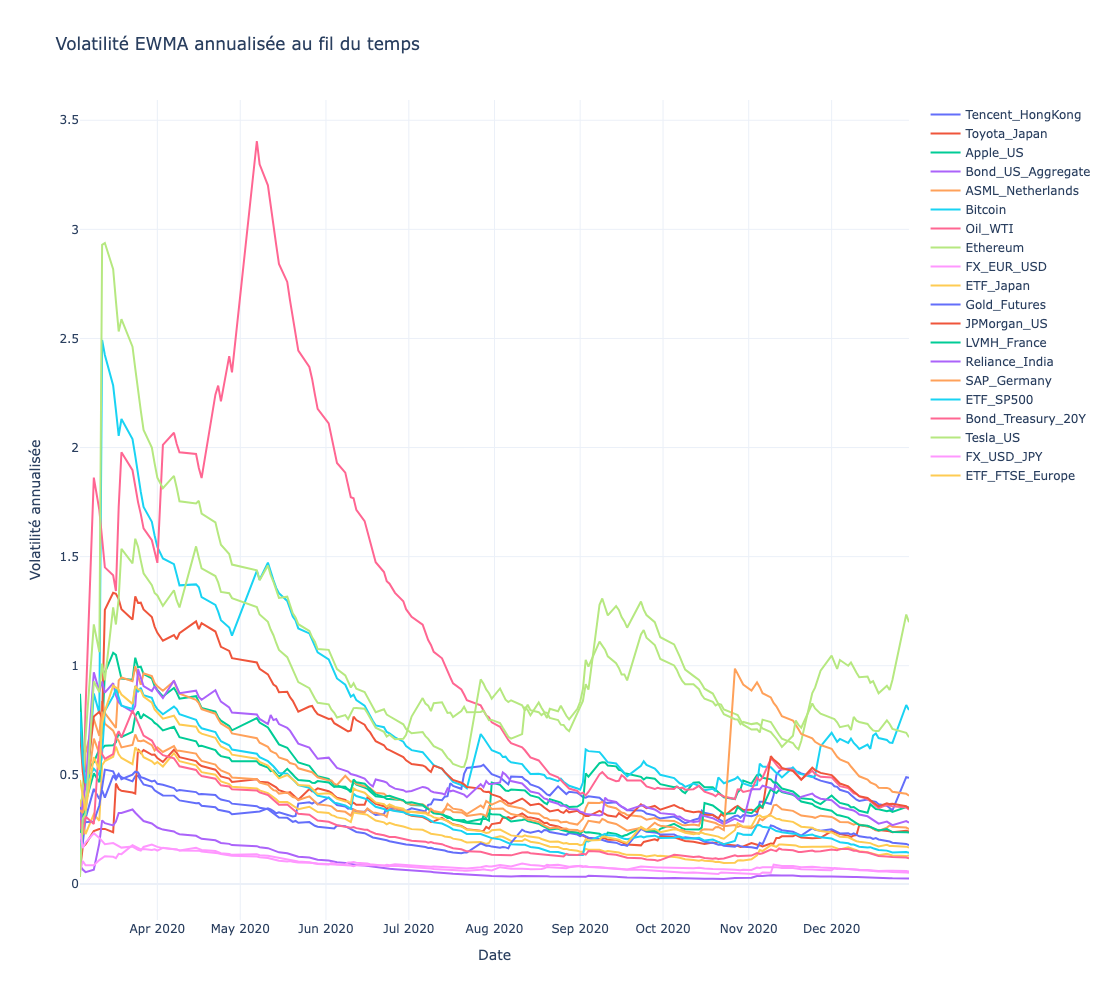

In [172]:
ewma_vol_clean = ewma_volatility.dropna()

fig3 = go.Figure()

for column in ewma_vol_clean.columns:
    fig3.add_trace(go.Scatter(
        x=ewma_vol_clean.index,
        y=ewma_vol_clean[column],
        mode='lines',
        name=column,
        hovertemplate='<b>%{fullData.name}</b><br>' +
                      'Date: %{x|%Y-%m-%d}<br>' +
                      'Volatilité: %{y:.2%}<extra></extra>'
    ))

fig3.update_layout(
    title='Volatilité EWMA annualisée au fil du temps',
    xaxis_title='Date',
    yaxis_title='Volatilité annualisée',
    hovermode='x unified',
    height=1000,
    template='plotly_white'
)

fig3.show()

### 4. GARCH

Le modèle GARCH est un modèle autorégressif généralisé qui capture les regroupements de volatilité des rendements par le biais de la variance conditionnelle.

En d'autres termes, le modèle GARCH trouve la volatilité moyenne à moyen terme grâce à une autorégression qui dépend de la somme des chocs décalés et de la somme des variances décalées.

Si nous voyons la volatilité historique pondérée, nous vérifions la référence aux modèles ARCH et GARCH pour ajuster le paramètre p à la réalité. Le paramètre p est le poids pour chaque distance entre l'observation t et sa moyenne au carré (perturbation au carré).

GARCH signifie modèle autorégressif généralisé conditionnel hétéroscédastique, de l'anglais,Hétéroscédasticité conditionnelle autorégressive généralisée.

Généralisé car il prend en compte à la fois les observations récentes et historiques.
Autorégressif car la variable dépendante retourne sur elle-même.
Conditionnel car la variance future dépend de la variance historique.
hétérocédastique car la variance varie en fonction des observations.



GARCH signifie modèle autorégressif généralisé conditionnel hétéroscédastique, de l'anglais,Hétéroscédasticité conditionnelle autorégressive généralisée.

Généralisé car il prend en compte à la fois les observations récentes et historiques.
Autorégressif car la variable dépendante retourne sur elle-même.
Conditionnel car la variance future dépend de la variance historique.
hétérocédastique car la variance varie en fonction des observations.



In [173]:
garch_volatility_all = pd.DataFrame(index=log_returns.index)
garch_models = {}


for asset in log_returns.columns:
    
    try:
        
        returns = log_returns[asset] * 100
        
       
        model = arch_model(returns, vol='Garch', p=10, q=10)
        fitted = model.fit(disp='off')
        

        garch_volatility_all[asset] = fitted.conditional_volatility / 100 * np.sqrt(252)
        garch_models[asset] = fitted
        
    except Exception as e:
        print(f"Erreur pour {asset}: {str(e)}")
        
print(garch_volatility_all.tail())

            Tencent_HongKong  Toyota_Japan  Apple_US  Bond_US_Aggregate  \
Date                                                                      
2020-12-21          0.339270      0.187966  0.440215           0.018448   
2020-12-22          0.342903      0.210166  0.334955           0.016603   
2020-12-23          0.337823      0.224071  0.269862           0.017749   
2020-12-28          0.346354      0.203912  0.347485           0.021521   
2020-12-29          0.394329      0.346301  0.291292           0.020072   

            ASML_Netherlands   Bitcoin   Oil_WTI  Ethereum  FX_EUR_USD  \
Date                                                                     
2020-12-21          0.222970  0.573781  0.256927  0.866485    0.063096   
2020-12-22          0.283643  0.532302  0.289263  0.980593    0.070748   
2020-12-23          0.328456  0.670771  0.376243  0.887000    0.065913   
2020-12-28          0.267656  0.758100  0.279427  1.077747    0.054974   
2020-12-29          0.273894  

In [174]:
vol_garch_df = garch_volatility_all.iloc[-1].reset_index()
vol_garch_df.columns = ['Actif', 'Volatilité']
vol_garch_df['% Volatilité'] = (vol_garch_df['Volatilité'] * 100).round(2)
vol_garch_df = vol_garch_df.sort_values('Volatilité')

fig4 = px.bar(vol_garch_df, 
             y='Actif', 
             x='Volatilité',
             orientation='h',
             color='Volatilité',
             color_continuous_scale='RdYlGn_r',
             text='% Volatilité',
             labels={'Volatilité': 'Volatilité annualisée'},
             title=f'Volatilité GARCH')

fig4.update_traces(texttemplate='%{text:.2f}%', textposition='outside')
fig4.update_layout(height=600, showlegend=False)
fig4.show()

### Analyse